# Gradient Descent and Optimization In Deep Learning

In this notebook we'll implement gradient descent with and without momentum using PyTorch. We'll also visualize our gradient updates on Ackley's function as movement along the contour plots. We’ll then discuss and benchmark several optimizers for an image classification task using the CIFAR10 dataset, and train a ResNet18 for this purpose.

Optimizers covered include:
* Nesterov momentum
* Adam
* AdaGrad
* AdaMax
* AdamW
* AdaDelta


For a more detailed breakdown of the theory behind the code, check out the full tutorial [on the blog](https://blog.paperspace.com/optimization-in-deep-learning/).

In [1]:
# !pip install tqdm

You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
import torch
from torch import nn
from torch import optim
from torch.utils.data import RandomSampler, DataLoader

from torchvision import models
from torchvision import transforms
from torchvision.datasets import CIFAR10 as cifar
from torchvision import datasets

import copy
import time
import pickle
import random
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt

In [ ]:
def gradient(f, X, h):
    grad = []
    for i in range(len(X)):
        Xgplus = np.array([x if not i == j else x + h for j, x in enumerate(X)])
        Xgminus = np.array([x if not i == j else x - h for j, x in enumerate(X)])
        grad.append(f(*Xgplus) - f(*Xgminus) / (2 * h))
    return np.array(grad)

In [ ]:
def vanilla_update(epoch, X, f, lr, h):
    grad = gradient(f, X, h)
    X1 = np.zeros_like(X)
    for i in range(len(X)):
        X1[i] = X[i] - lr * grad[i]
    print('epoch: ', epoch, 'point: ', X1, 'gradient: ', grad)
    return X1

In [ ]:
def ackleys_function(x, y):
    return - 20 * np.exp(- 0.2 * np.sqrt(0.5 * (x ** 2 + y ** 2))) \
           - np.exp(0.5 * (np.cos(2 * np.pi * x) + np.cos(2 * np.pi * y))) \
           + np.e + 20

In [ ]:
h = 1e-3
f = ackleys_function
point = np.array([-2., -2.])
i = 0
lr = 0.00001
while True:
    new_point = vanilla_update(i+1, point, f, lr, h)
    if np.sum(abs(new_point - point)) < h:
        print('Converged.')
        break
    point = new_point
    i += 1

In [ ]:
def momentum_update(epoch, X, f, lr, m, h, vel=[]):
    grad = gradient(f, X, h)
    X1 = np.zeros_like(X)
    for i in range(len(X)):
        vel[i] = m * vel[i] + lr * grad[i]
        X1[i] = X[i] - vel[i]
    print('epoch: ', epoch, 'point: ', X1, 'gradient: ', grad, 'velocity: ', vel)
    return X1, vel

In [ ]:
h = 1e-3
f = ackleys_function
point = np.array([-2., -2.])
vel = np.zeros_like(point)
i = 0
lr = 0.00001
m = 0.9
grads = []
while True:
    new_point, vel = momentum_update(i+1, point, f, lr, m, h, vel=vel)
    if np.sum(abs(new_point - point)) < h:
        print('Converged.')
        break
    point = new_point
    i += 1

In [ ]:
from matplotlib import pyplot as plt
from mpl_toolkits import mplot3d

def get_scatter_plot(X, Y, function):
    Z = function(X, Y)
    fig = plt.figure()
    cm = plt.cm.get_cmap('viridis')
    plt.scatter(X, Y, c=Z, cmap=cm)
    plt.show()
    return fig


def get_contours(X, Y, function):
    Z = function(X, Y)
    fig = plt.figure()
    contours = plt.contour(X, Y, Z, colors='black',
                           linestyles='dashed',
                           linewidths=1)
    plt.clabel(contours, inline=1, fontsize=10)
    plt.contourf(X, Y, Z)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.show()
    return fig


def get_3d_contours(X, Y, function):
    Z = function(X, Y)
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    cm = plt.cm.get_cmap('viridis')
    ax.contour3D(X, Y, Z, 100, cmap=cm)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    plt.show()
    return fig
    
def get_surface_plot(X, Y, function):
    Z = function(X, Y)
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    cm = plt.cm.get_cmap('viridis')
    ax.plot_surface(X, Y, Z, rstride=1,
                    cstride=1, cmap=cm)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    plt.show()
    return fig

In [ ]:
x = np.linspace(-1, 1, 1000)
X, Y = np.meshgrid(x, x)

In [ ]:
get_scatter_plot(X, Y, ackleys_function)

In [ ]:
get_contours(X, Y, ackleys_function)

In [ ]:
get_3d_contours(X, Y, ackleys_function)

In [ ]:
get_surface_plot(X, Y, ackleys_function)

In [ ]:
x = np.linspace(-2, 2, 1000)

h = 1e-3

f = ackleys_function

a, b = np.meshgrid(x, x)
Z = f(a, b)
contours = plt.contour(a, b, Z, colors='black',
                       linestyles='dashed',
                       linewidths=1)
plt.clabel(contours, inline=1, fontsize=10)
plt.contourf(a, b, Z)
plt.xlabel('X')
plt.ylabel('Y')

point = np.array([-2., -2.])

i = 0
lr = 0.00001
while True:
    new_point = vanilla_update(i+1, point, f, lr, h)
    plt.plot(*point, 'ro', ms=1)
    if np.sum(abs(new_point - point)) < h:
        print('Converged.')
        break
    point = new_point
    i += 1

plt.show()

In [ ]:
x = np.linspace(-2, 2, 1000)

h = 1e-3

f = ackleys_function

a, b = np.meshgrid(x, x)
Z = f(a, b)
contours = plt.contour(a, b, Z, colors='black',
                       linestyles='dashed',
                       linewidths=1)
plt.clabel(contours, inline=1, fontsize=10)
plt.contourf(a, b, Z)
plt.xlabel('X')
plt.ylabel('Y')

point = np.array([-2., -2.])
vel = np.zeros_like(point)

i = 0
lr = 0.00001
m = 0.1
grads = []
while True:
    new_point, vel = momentum_update(i+1, point, f, lr, m, h, vel=vel)
    plt.plot(*point, 'bo', ms=1)
    if np.sum(abs(new_point - point)) < h:
        print('Converged.')
        break
    point = new_point
    i += 1
plt.show()

In [3]:
torch.manual_seed(0)
torch.cuda.manual_seed(0)
np.random.seed(0)
random.seed(0)

In [4]:
DATA_PATH = 'cifar'


trans = transforms.Compose(
            [
                transforms.RandomHorizontalFlip(),
                transforms.RandomCrop(32, padding=4),
                transforms.ToTensor(),
                transforms.Normalize(
                    mean=[n/255. for n in [129.3, 124.1, 112.4]], 
                    std=[n/255. for n in [68.2,  65.4,  70.4]]
                )
        ]
    )


train = cifar(DATA_PATH, train=True, transform=trans, download=False)
test = cifar(DATA_PATH, train=False, transform=trans, download=False)

In [5]:
batch_size = 32
train_size = len(train)
test_size = len(test)

train_dataloader = DataLoader(train, shuffle=True, batch_size=batch_size)
test_dataloader = DataLoader(test, shuffle=False, batch_size=batch_size)

In [6]:
class Cifar10_Resnet18(nn.Module):

    def __init__(self,):
        super(Cifar10_Resnet18, self).__init__()
        self.base = models.resnet18(pretrained=True)
        self.classification = nn.Linear(in_features=1000, out_features=10)

        
    def forward(self, inputs):
        out = self.base(inputs)
        out = self.classification(out)
        return out

In [7]:
device = torch.device(type='cuda')

In [8]:
optimizers = {
        'SGD': 'optim.SGD(model.parameters(), lr=0.01, momentum=0.9)',
        'Adam': 'optim.Adam(model.parameters())',
        'Adadelta': 'optim.Adadelta(model.parameters())',
        'Adagrad': 'optim.Adagrad(model.parameters())',
        'AdamW': 'optim.AdamW(model.parameters())',
        'Adamax': 'optim.Adamax(model.parameters())',
        'ASGD': 'optim.ASGD(model.parameters())',
    }

In [9]:
epochs = 50

optim_keys = list(optimizers.keys())

train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

In [10]:
for i, optim_key in enumerate(optim_keys):
    print('-------------------------------------------------------')
    print('Optimizer:', optim_key)
    print('-------------------------------------------------------')
    print("{:<8} {:<25} {:<25} {:<25} {:<25} {:<25}".format('Epoch', 'Train Acc', 'Train Loss', 'Val Acc', 'Val Loss', 'Train Time'))
    
    model = Cifar10_Resnet18()
    model.to(device)

    optimizer = eval(optimizers[optim_key])
    criterion = nn.CrossEntropyLoss()
    
    model.train()
    
    optim_train_acc = []
    optim_test_acc = []
    optim_train_loss = []
    optim_test_loss = []

    for epoch in range(epochs):

        start = time.time()

        epoch_loss = []
        epoch_accuracy = []
        
        for step, batch in enumerate(train_dataloader):
            
            optimizer.zero_grad()
            
            batch = tuple(t.to(device) for t in batch)
            images, labels = batch
            
            out = model(images)
            
            loss = criterion(out, labels)
            
            confidence, predictions = out.max(dim=1)
            truth_values = predictions == labels
            acc = truth_values.sum().float().detach().cpu().numpy() / truth_values.shape[0]
            
            epoch_accuracy.append(acc)
            epoch_loss.append(loss.float().detach().cpu().numpy().mean())
            
            loss.backward()
            optimizer.step()
        
        optim_train_loss.append(np.mean(epoch_loss))
        optim_train_acc.append(np.mean(epoch_accuracy))
        
        test_epoch_loss = []
        test_epoch_accuracy = []
        
        end = time.time()
        
        model.eval()
        for step, batch in enumerate(test_dataloader):
            
            batch = tuple(t.to(device) for t in batch)
            images, labels = batch
            
            out = model(images)
            
            loss = criterion(out, labels)
            
            confidence, predictions = out.max(dim=1)
            truth_values = predictions == labels
            acc = truth_values.sum().float().detach().cpu().numpy() / truth_values.shape[0]
            
            test_epoch_accuracy.append(acc)
            test_epoch_loss.append(loss.float().detach().cpu().numpy().mean())
        
        optim_test_loss.append(np.mean(test_epoch_loss))
        optim_test_acc.append(np.mean(test_epoch_accuracy))
        
        print("{:<8} {:<25} {:<25} {:<25} {:<25} {:<25}".format(epoch+1, 
                                                                np.mean(epoch_accuracy), 
                                                                np.mean(epoch_loss), 
                                                                np.mean(test_epoch_accuracy), 
                                                                np.mean(test_epoch_loss), 
                                                                end-start))
    
    train_losses.append(optim_train_loss)
    test_losses.append(optim_test_loss)
    train_accuracies.append(optim_train_acc)
    test_accuracies.append(optim_train_acc)

-------------------------------------------------------
Optimizer: SGD
-------------------------------------------------------
Epoch    Train Acc                 Train Loss                Val Acc                   Val Loss                  Train Time               
1        0.21535543130990414       2.339431047439575         0.2770567092651757        2.0045716762542725        15.16554307937622        
2        0.290435303514377         1.8527964353561401        0.30870607028753994       1.7894388437271118        15.073749780654907       
3        0.3597244408945687        1.7016133069992065        0.3315694888178914        1.7538025379180908        15.106250047683716       
4        0.4034544728434505        1.60513436794281          0.3985623003194888        1.5783556699752808        15.124638319015503       
5        0.43540335463258784       1.525390863418579         0.42711661341853036       1.5352096557617188        15.132255554199219       
---------------------------------------

In [11]:
train_accuracies = dict(zip(optim_keys, train_accuracies))
test_accuracies = dict(zip(optim_keys, test_accuracies))
train_losses = dict(zip(optim_keys, train_losses))
test_losses = dict(zip(optim_keys, test_losses))

with open('train_accuracies', 'wb') as f:
    pickle.dump(train_accuracies, f)
with open('train_losses', 'wb') as f:
    pickle.dump(train_losses, f)
with open('test_accuracies', 'wb') as f:
    pickle.dump(test_accuracies, f)
with open('test_losses', 'wb') as f:
    pickle.dump(test_losses, f)

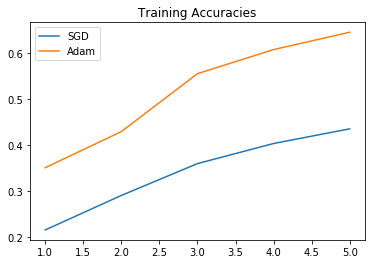

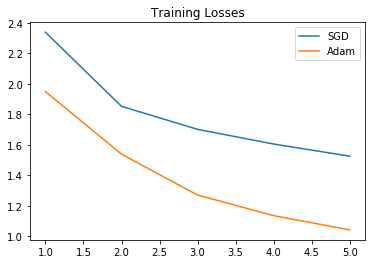

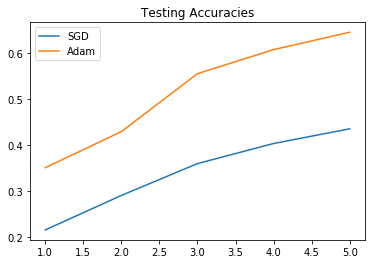

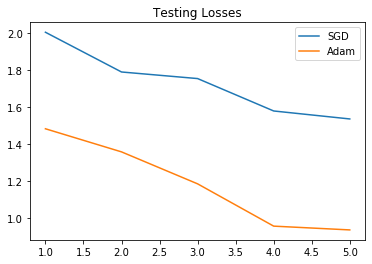

In [12]:
x = np.arange(epochs) + 1

for optim_key in optim_keys:
    plt.plot(x, train_accuracies[optim_key], label=optim_key)

plt.title('Training Accuracies')
plt.legend()
plt.show()


for optim_key in optim_keys:
    plt.plot(x, train_losses[optim_key], label=optim_key)

plt.title('Training Losses')
plt.legend()
plt.show()


for optim_key in optim_keys:
    plt.plot(x, test_accuracies[optim_key], label=optim_key)

plt.title('Testing Accuracies')
plt.legend()
plt.show()


for optim_key in optim_keys:
    plt.plot(x, test_losses[optim_key], label=optim_key)

plt.title('Testing Losses')
plt.legend()
plt.show()